# import libraries

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import re
from galvani import BioLogic

from function import read_mpr

import pymysql
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.widgets import Slider,CheckButtons

from scipy.signal import savgol_filter,filtfilt,butter

# import raw data to MySQL

## read mpr files to pandas dataframe

### read Formation data

In [2]:
#load data from folder
ds = read_mpr.mpr_pandas('raw_data/form')

In [3]:
read_mpr.searchmpr('raw_data/form')

['raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA1.mpr',
 'raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA1.mpr',
 'raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA1.mpr',
 'raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA1.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA2.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA2.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA2.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA2.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA3.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_02_GCPL_CA3.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_03_GEIS_CA3.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_04_GCPL_CA3.mpr',
 'raw_data/form\\Cell004_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA4.mpr',
 'raw_data/form\\Cell004_Form_50uA_25T_30RH_Cycle1t

In [4]:
ds[1][ds[1]['cycle_Nr']==3]

,flags,Ns,time/s,dQ/mA.h,(Q-Qo)/mA.h,control/V/mA,Ewe/V,I Range,Q charge/discharge/mA.h,half cycle,loop_Nr,cycle_Nr
56952,7,0,578908.787122,-2.890050e-10,-2.890050e-10,0.00,0.027646,115,1.302664,0,2,3
56953,7,0,578913.787122,0.000000e+00,-2.890050e-10,0.00,0.025638,115,1.302664,0,2,3
56954,23,0,578918.869123,0.000000e+00,-2.890050e-10,0.02,0.035127,117,1.302664,0,2,3
56955,53,1,578918.871123,1.108816e-08,1.079916e-08,0.02,0.035402,117,1.302664,0,2,3
56956,21,1,578923.871123,2.773189e-05,2.774268e-05,0.02,0.052333,117,1.302692,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...
80380,23,1,696022.625338,0.000000e+00,5.289467e-01,0.00,2.202864,115,1.831611,0,2,3
80381,23,1,696027.625338,0.000000e+00,5.289467e-01,0.00,2.202745,115,1.831611,0,2,3
80382,23,1,696032.625339,0.000000e+00,5.289467e-01,0.00,2.202745,115,1.831611,0,2,3
80383,23,1,696037.517339,0.000000e+00,5.289467e-01,0.00,2.202706,115,1.831611,0,2,3


### read Cycling data

In [5]:
cyc_files = read_mpr.searchmpr('raw_data/cycle1')

In [6]:
read_mpr.searchmpr('raw_data/cycle1')

['raw_data/cycle1\\Cell001_Cyc_20uA_25T_30RH_Cycle11to100_01_GEIS_CA1.mpr',
 'raw_data/cycle1\\Cell001_Cyc_20uA_25T_30RH_Cycle11to100_02_GCPL_CA1.mpr',
 'raw_data/cycle1\\Cell002_Cyc_20uA_25T_30RH_Cycle11to100_01_GEIS_CA2.mpr',
 'raw_data/cycle1\\Cell002_Cyc_20uA_25T_30RH_Cycle11to100_02_GCPL_CA2.mpr',
 'raw_data/cycle1\\Cell003_Cyc_50uA_25T_30RH_Cycle11to100_01_GEIS_CA3.mpr',
 'raw_data/cycle1\\Cell003_Cyc_50uA_25T_30RH_Cycle11to100_02_GCPL_CA3.mpr',
 'raw_data/cycle1\\Cell004_Cyc_50uA_25T_30RH_Cycle11to100_01_GEIS_CA4.mpr',
 'raw_data/cycle1\\Cell004_Cyc_50uA_25T_30RH_Cycle11to100_02_GCPL_CA4.mpr',
 'raw_data/cycle1\\Cell005_Cyc_100uA_25T_30RH_Cycle11to100_01_GEIS_CA5.mpr',
 'raw_data/cycle1\\Cell005_Cyc_100uA_25T_30RH_Cycle11to100_02_GCPL_CA5.mpr',
 'raw_data/cycle1\\Cell006_Cyc_100uA_25T_30RH_Cycle11to100_01_GEIS_CA6.mpr',
 'raw_data/cycle1\\Cell006_Cyc_100uA_25T_30RH_Cycle11to100_02_GCPL_CA6.mpr',
 'raw_data/cycle1\\Cell007_Cyc_200uA_25T_30RH_Cycle11to100_01_GEIS_CA7.mpr',
 'raw_d

In [102]:
for file in cyc_files:
    try:
        BioLogic.MPRfile(file)
    except:
        print('files: '+file+' is unreadable')

files: raw_data/cycle1\Cell001_Cyc_20uA_25T_30RH_Cycle11to100_02_GCPL_CA1.mpr is unreadable
files: raw_data/cycle1\Cell005_Cyc_100uA_25T_30RH_Cycle11to100_02_GCPL_CA5.mpr is unreadable
files: raw_data/cycle1\Cell006_Cyc_100uA_25T_30RH_Cycle11to100_02_GCPL_CA6.mpr is unreadable


similar issue: https://github.com/echemdata/galvani/issues/39

In [87]:
BioLogic.MPRfile('raw_data/cycle\Cell001_Cyc_20uA_25T_30RH_Cycle11to100_02_GCPL_CA1.mpr').data

array([( 7, 0,    1676.07407961, -2.58971947e-10, -2.58971947e-10,  0.0000000e+00,  0.02292111, 115, -2.58971947e-10,  0),
       ( 7, 0,    1681.07407985,  0.00000000e+00, -2.58971947e-10,  0.0000000e+00,  0.02390544, 115, -2.58971947e-10,  0),
       (23, 0,    1686.10008009,  0.00000000e+00, -2.58971947e-10,  2.0000001e-02,  0.03445749, 117, -2.58971947e-10,  0),
       ...,
       (18, 2, 1517068.30796032, -2.67193185e-06,  1.59106733e-02, -5.0695737e-05, -0.00034852, 117, -1.68252081e-01, 21),
       (18, 2, 1517073.30796092, -2.66723424e-06,  1.59080060e-02, -5.0695737e-05, -0.00030914, 117, -1.68254748e-01, 21),
       (18, 2, 1517078.30796151, -2.66391771e-06,  1.59053421e-02, -5.0695737e-05, -0.00038789, 117, -1.68257412e-01, 21)],
      dtype=[('flags', 'u1'), ('Ns', '<u2'), ('time/s', '<f8'), ('dQ/mA.h', '<f8'), ('(Q-Qo)/mA.h', '<f8'), ('control/V/mA', '<f4'), ('Ewe/V', '<f4'), ('I Range', '<u2'), ('Q charge/discharge/mA.h', '<f8'), ('half cycle', '<u4')])

## add serval columns

In [7]:
# list paths of data in .mpr file
datafilespath = glob('raw_data/form/*.mpr')
datafilespath =  [os.path.basename(x) for x in datafilespath]

In [8]:
datafilespath

['Cell001_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA1.mpr',
 'Cell001_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA1.mpr',
 'Cell001_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA1.mpr',
 'Cell001_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA1.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA2.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA2.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA2.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA2.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA3.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_02_GCPL_CA3.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_03_GEIS_CA3.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_04_GCPL_CA3.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA4.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_02_GCPL_CA4.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_03_GEIS_CA4.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_04_GCPL_CA4.mpr',
 'Cell005_Form_100uA_25T_30RH_Cycle1to10_01_GEIS_CA5.mpr',
 'Cell005_For

### half cycle and state of charge

In [123]:
#set half cycle of discharge processes to 1 in gcpl
#ds[3,7,11...]
discharge_index = np.arange(3,np.shape(datafilespath)[0],4)
for index in discharge_index:
    ds[index]['half cycle']=1
#set state of charge in geis
cell_empty_index = np.arange(0,np.shape(datafilespath)[0],4)
cell_full_index = np.arange(2,np.shape(datafilespath)[0],4)
for index in cell_empty_index:
    ds[index]['state of charge']=0
for index in cell_full_index:
    ds[index]['state of charge']=1

# import dataframes to Mysql

## Structure 1:    
cell001:     
-step01_geis    
-step02_gcpl    
-step03_geis    
-step04_gcpl    

In [27]:
##structure 1
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword)
print('connection succeed')


cursor = Connection.cursor()
cursor.execute('DROP DATABASE IF EXISTS cell_configuration;')
cursor.execute('CREATE DATABASE cell_configuration;')

##cell configuration
engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db='cell_configuration', user=dbuser, pw=dbpassword))
read_mpr.filename_read(datafilespath).to_sql('cell_configuration', engine, if_exists='fail',index=False)
print('table cell_configuration created')

Cell_ID = np.unique([x.split('_')[0] for x in datafilespath])
Unique_Index = np.append(np.unique([x.split('_')[0] for x in datafilespath],return_index=True)[1],len(ds))
Tech_Type = [x.split('_')[-2].lower() for x in datafilespath]

##labor data
for i in range(len(Cell_ID)):
    cursor.execute('DROP DATABASE IF EXISTS '+Cell_ID[i])
    cursor.execute('CREATE DATABASE '+Cell_ID[i])
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=Cell_ID[i], user=dbuser, pw=dbpassword))
    step_ID = [x.split('_')[-3] for x in datafilespath]
    # capacity
    
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        if step_ID[j]=='02':
            ds[j].to_sql('step'+step_ID[j]+'_'+'charge', engine, if_exists='fail',index=False)
        elif step_ID[j]=='04':
            ds[j].to_sql('step'+step_ID[j]+'_'+'discharge', engine, if_exists='fail',index=False)
        else:
            ds[j].to_sql('step'+step_ID[j]+'_'+Tech_Type[j], engine, if_exists='fail',index=False)
            
        print('table '+'step'+step_ID[j]+'_'+Tech_Type[j]+' of '+Cell_ID[i]+' created')
        
print('All data loaded')


connection succeed
table cell_configuration created
table step01_geis of Cell001 created
table step02_gcpl of Cell001 created
table step03_geis of Cell001 created
table step04_gcpl of Cell001 created
table step01_geis of Cell002 created
table step02_gcpl of Cell002 created
table step03_geis of Cell002 created
table step04_gcpl of Cell002 created
table step01_geis of Cell003 created
table step02_gcpl of Cell003 created
table step03_geis of Cell003 created
table step04_gcpl of Cell003 created
table step01_geis of Cell004 created
table step02_gcpl of Cell004 created
table step03_geis of Cell004 created
table step04_gcpl of Cell004 created
table step01_geis of Cell005 created
table step02_gcpl of Cell005 created
table step03_geis of Cell005 created
table step04_gcpl of Cell005 created
table step01_geis of Cell006 created
table step02_gcpl of Cell006 created
table step03_geis of Cell006 created
table step04_gcpl of Cell006 created
table step01_geis of Cell007 created
table step02_gcpl of Ce

## Structure 2:    
cell001:    
-geis    
-gcpl    

In [8]:
#structure 2
#We prefer this structure!
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword)
print('connection succeed')


cursor = Connection.cursor()
cursor.execute('DROP DATABASE IF EXISTS cell_configuration;')
cursor.execute('CREATE DATABASE cell_configuration;')

##cell configuration
engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db='cell_configuration', user=dbuser, pw=dbpassword))
read_mpr.filename_read(datafilespath).to_sql('cell_configuration', engine, if_exists='fail',index=False)
print('table cell_configuration created')

Cell_ID = np.unique([x.split('_')[0] for x in datafilespath])
Unique_Index = np.append(np.unique([x.split('_')[0] for x in datafilespath],return_index=True)[1],len(ds))
Tech_Type = [x.split('_')[-2].lower() for x in datafilespath]

##labor data
for i in range(len(Cell_ID)):
    cursor.execute('DROP DATABASE IF EXISTS '+Cell_ID[i])
    cursor.execute('CREATE DATABASE '+Cell_ID[i])
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=Cell_ID[i], user=dbuser, pw=dbpassword))
    step_ID = [x.split('_')[-3] for x in datafilespath]
    
    geis_data_index=[]
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        if j in np.where(np.array(Tech_Type)== 'geis')[0]:
            geis_data_index = np.append(geis_data_index,j)
    geis_data = pd.concat([ds[int(k)] for k in geis_data_index],ignore_index=True)
    geis_data=geis_data.sort_values(by=['time/s'])
    geis_data.to_sql('geis', engine, if_exists='fail',index=False)
    print('geis data of '+Cell_ID[i]+ ' loaded')
    
    gcpl_data_index=[]
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        
        if j in np.where(np.array(Tech_Type)== 'gcpl')[0]:
            gcpl_data_index = np.append(gcpl_data_index,j)
    gcpl_data = pd.concat([ds[int(k)] for k in gcpl_data_index],ignore_index=True)
    gcpl_data=gcpl_data.sort_values(by=['time/s'])
    gcpl_data.to_sql('gcpl', engine, if_exists='fail',index=False)    
    print('gcpl data of '+Cell_ID[i]+ ' loaded')    

        
print('All data loaded')


connection succeed
table cell_configuration created
geis data of Cell001 loaded
gcpl data of Cell001 loaded
geis data of Cell002 loaded
gcpl data of Cell002 loaded
geis data of Cell003 loaded
gcpl data of Cell003 loaded
geis data of Cell004 loaded
gcpl data of Cell004 loaded
geis data of Cell005 loaded
gcpl data of Cell005 loaded
geis data of Cell006 loaded
gcpl data of Cell006 loaded
geis data of Cell007 loaded
gcpl data of Cell007 loaded
geis data of Cell008 loaded
gcpl data of Cell008 loaded
All data loaded


# Savitzky-Golay filter

## charge/discharge curve

In [207]:
# query data from MySQL
##cell001, gcpl, structure 2
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db='cell001'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword,
                          database=db)
# structure 1
# ## charge step
# sql = 'SELECT `(Q-Qo)/mA.h`,`Ewe/V`, `time/s` from step02_charge'
# cursor = Connection.cursor()
# cursor.execute(sql)

# charge = cursor.fetchall()
# charge = np.array(charge)
# ##discharge step
# sql = 'SELECT `(Q-Qo)/mA.h`,`Ewe/V`, `time/s` from step04_discharge'
# cursor.execute(sql)

# discharge = cursor.fetchall()
# discharge = np.array(discharge)

# structue 2
sql = 'SELECT `(Q-Qo)/mA.h`,`Ewe/V`, `time/s` FROM gcpl'
cursor = Connection.cursor()
cursor.execute(sql)
curve = cursor.fetchall()
curve = np.array(curve)

<IPython.core.display.Javascript object>


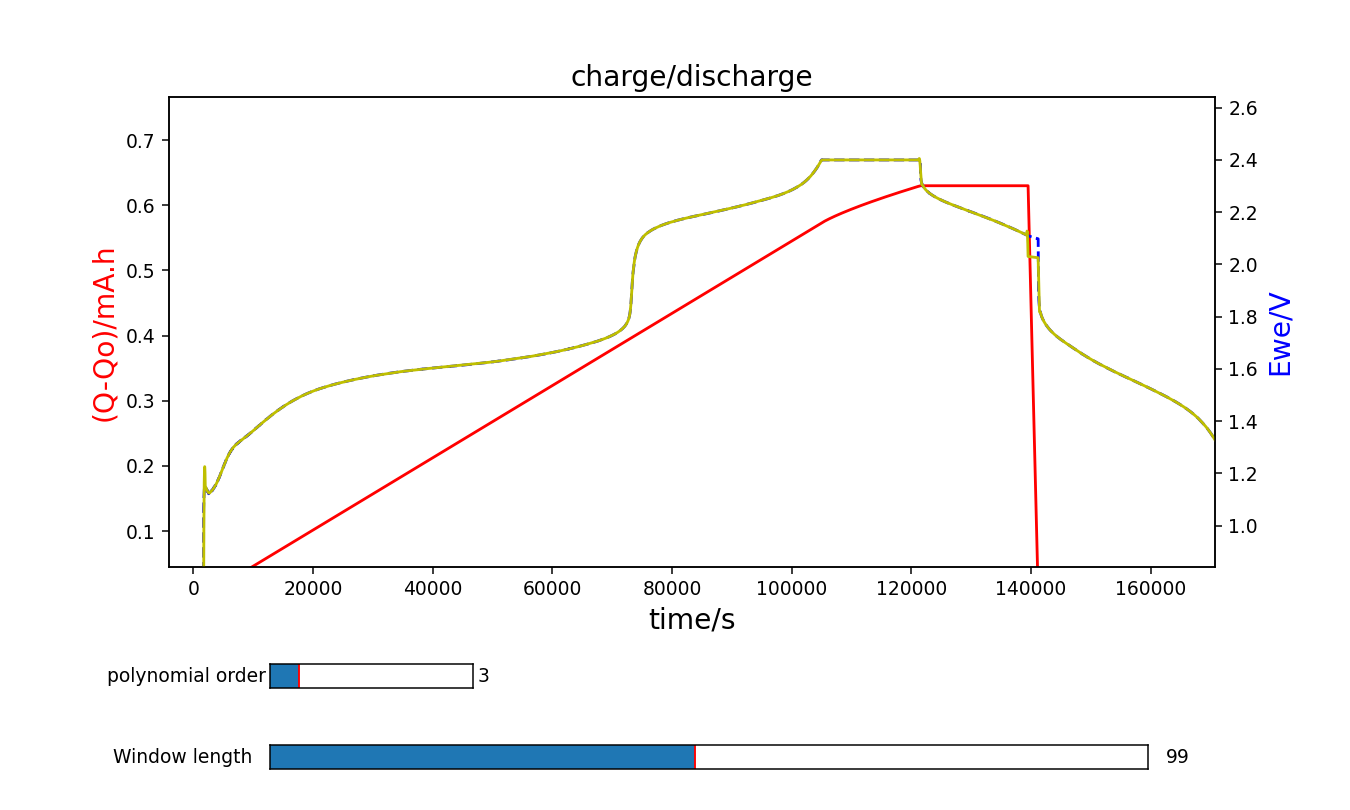

In [208]:
# curve=np.concatenate((charge,discharge))
# curve=curve[curve[:, 2].argsort()]
%matplotlib notebook
## plot curves
fig,ax = plt.subplots(figsize=(10,6))
plt.subplots_adjust(bottom=0.3)
ax.set_title('charge/discharge',fontsize=15)
ax.plot(curve[:,2], curve[:,0], color="red")
#ax.plot(charge[:,2], charge[:,0], color="red")
#ax.plot(discharge[:,2], -discharge[:,0], color="yellow")
ax.axhline(0,color='black',linestyle='--')
ax.set_xlabel("time/s",fontsize=15)
ax.set_ylabel("(Q-Qo)/mA.h",color="red",fontsize=15)

ax2=ax.twinx()
ax2.plot(curve[:,2], curve[:,1],"b--")
ax2.set_ylabel("Ewe/V",color="blue",fontsize=15)


p, = ax2.plot(curve[:,2], savgol_filter(curve[:,1],111,3), "y")

## define the slides
ax_slide1 = plt.axes([0.2,0.05,0.65,0.03])
ax_slide2 = plt.axes([0.2,0.15,0.15,0.03])

## properties of slides
win_len = Slider(ax_slide1,'Window length', valmin = 5,valmax = 199,valinit = 99,valstep = 2)
p_order = Slider(ax_slide2,'polynomial order', valmin = 2,valmax = 9,valinit = 3,valstep = 1)

## updating function
def update(val):
    current_win_len = int(win_len.val)
    current_p_order = int(p_order.val)
    p.set_ydata(savgol_filter(curve[:,1],current_win_len,current_p_order))
    fig.canvas.draw()
    
win_len.on_changed(update)
p_order.on_changed(update)

plt.show()


# cell capacity
create a table of each cell to discribe its capacity in all loops

In [189]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db=np.unique([x.split('_')[0] for x in datafilespath])

for cell in db:
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)

    sql = 'SELECT `(Q-Qo)/mA.h`,`cycle_Nr`, `half cycle` FROM ' +cell+ '.gcpl'
    cellx_df = pd.read_sql(sql, Connection)
    cycle_Nr = np.unique(cellx['cycle_Nr'])
    charge=[]
    discharge=[]
    for cycle in cycle_Nr:
        charge.append(cellx_df[(cellx_df['cycle_Nr']==cycle) & (cellx_df['half cycle']==0)]['(Q-Qo)/mA.h'].max())
        discharge.append(cellx_df[(cellx_df['cycle_Nr']==cycle) & (cellx_df['half cycle']==1)]['(Q-Qo)/mA.h'].min())
    capacity = {'cycle_Nr':cycle_Nr,'Q_charge':charge,'Q_discharge':discharge,'CE/%':np.round(np.divide(np.abs(discharge),charge)*100,2)}
    capacity = pd.DataFrame(data=capacity)
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    capacity.to_sql('capacity', engine, if_exists='replace',index=False)
    print('table capacity of '+cell +' created')

table capacity of Cell001 created
table capacity of Cell002 created
table capacity of Cell003 created
table capacity of Cell004 created
table capacity of Cell005 created
table capacity of Cell006 created
table capacity of Cell007 created
table capacity of Cell008 created


# $V$,$\frac {dV}{dt}$,$\frac{d(\frac {dV}{dt})}{dt}$ vs. time

In [9]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db=np.unique([x.split('_')[0] for x in datafilespath])
v_dV_ddV_time=[]
for cell in db:
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)

    sql = 'SELECT `Ewe/V`,`time/s` FROM ' +cell+ '.gcpl'
    cellx_df = pd.read_sql(sql, Connection)

    V = cellx_df['Ewe/V']
    #savgol_filter
    win_len = 179
    p_order = 3
    V_sg = savgol_filter(V,win_len,p_order)
    
    t =cellx_df['time/s']
    #with savgol_filter
    dV_sg = np.divide(np.diff(V_sg,append=-1),np.diff(t,append=-1))
    ddV_sg = np.divide(np.diff(dV_sg,append=-1),np.diff(t,append=-1))
    #without savgpl_filter
    dV = np.divide(np.diff(V,append=-1),np.diff(t,append=-1))
    ddV = np.divide(np.diff(dV,append=-1),np.diff(t,append=-1))
    #apply filter twice
    ddV_sgsg = savgol_filter(ddV,win_len,p_order)
    
    
    
    v_dV_ddV_time = {'V':V,'V_sg':V_sg,'dV':dV,'dV_sg':dV_sg,'ddV':ddV,'ddV_sg':ddV_sg,'ddV_sgsg':ddV_sgsg,'t':t}
    v_dV_ddV_time = pd.DataFrame(data=v_dV_ddV_time)    
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    v_dV_ddV_time.to_sql('v_dv_ddv_time', engine, if_exists='replace',index=False)
    print('table v_dv_ddv_time of '+cell +' created')

table v_dv_ddv_time of Cell001 created
table v_dv_ddv_time of Cell002 created
table v_dv_ddv_time of Cell003 created
table v_dv_ddv_time of Cell004 created
table v_dv_ddv_time of Cell005 created
table v_dv_ddv_time of Cell006 created
table v_dv_ddv_time of Cell007 created
table v_dv_ddv_time of Cell008 created


In [248]:
# connection
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cell='cell005'
Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

# query from Mysql
sql = 'SELECT * FROM ' +cell+ '.v_dv_ddv_time'
cellx_df = pd.read_sql(sql, Connection)
sql = 'SELECT `(Q-Qo)/mA.h` FROM ' +cell+ '.gcpl'
Q = pd.read_sql(sql, Connection)

print('data queried')
V = cellx_df['V']
V_sg = cellx_df['V_sg']
t = cellx_df['t']
dV = cellx_df['dV']
dV_sg = cellx_df['dV_sg']
ddV = cellx_df['ddV']
ddV_sg = cellx_df['ddV_sg']
ddV_sgsg = cellx_df['ddV_sgsg']

data queried


In [249]:
## when V = 2.4 or 0(constant, actual value c.a. 2.399 and -0.0003) remove the impact of these sections of time 
## in this case dV/dt is 0 and doesn't make sense
dV[V>2.398]=np.nan
dV[V<-0.00001]=np.nan
dV_sg[V_sg>2.398]=np.nan
dV_sg[V_sg<-0.00001]=np.nan


nan_mask = np.ma.clump_masked(np.ma.masked_invalid(dV_sg))
for ma in nan_mask:
    ma = np.r_[ma]
    if ma[0]-100 <0:
        ma = np.append(np.array(range(0,ma[0])),ma)
    else:
        ma = np.append(np.array(range(ma[0]-100,ma[0])),ma)
    ma = np.append(ma,np.array(range(ma[-1],ma[-1]+100)))
    dV_sg[ma] = np.nan

In [250]:
# in dV and ddV, remove the data in EIS phases

## get the time points of all eis processes
sql = 'SELECT `time/s`,`loop_Nr`,`state of charge` FROM ' +cell+ '.geis'
eis_time = pd.read_sql(sql, Connection)
time=[]
for ln in np.unique(eis_time['loop_Nr']):
    for soc in np.unique(eis_time['state of charge']):
        start = eis_time[(eis_time['loop_Nr']==ln) & (eis_time['state of charge']==soc)]['time/s'].min()
        end = eis_time[(eis_time['loop_Nr']==ln) & (eis_time['state of charge']==soc)]['time/s'].max()
        time = np.append(time,[start,end])
time=time.reshape((-1,2))

## in dV and ddV, replace with np.nan
delta_t = 800
for start,end in time:
    dV[(t>start-3*delta_t)&(t<end+delta_t)] = np.nan
    dV_sg[(t>start-3*delta_t)&(t<end+delta_t)] = np.nan
    ddV[(t>start-delta_t)&(t<end+delta_t)] = np.nan
    ddV_sg[(t>start-3*delta_t)&(t<end+delta_t)] = np.nan

    

<IPython.core.display.Javascript object>


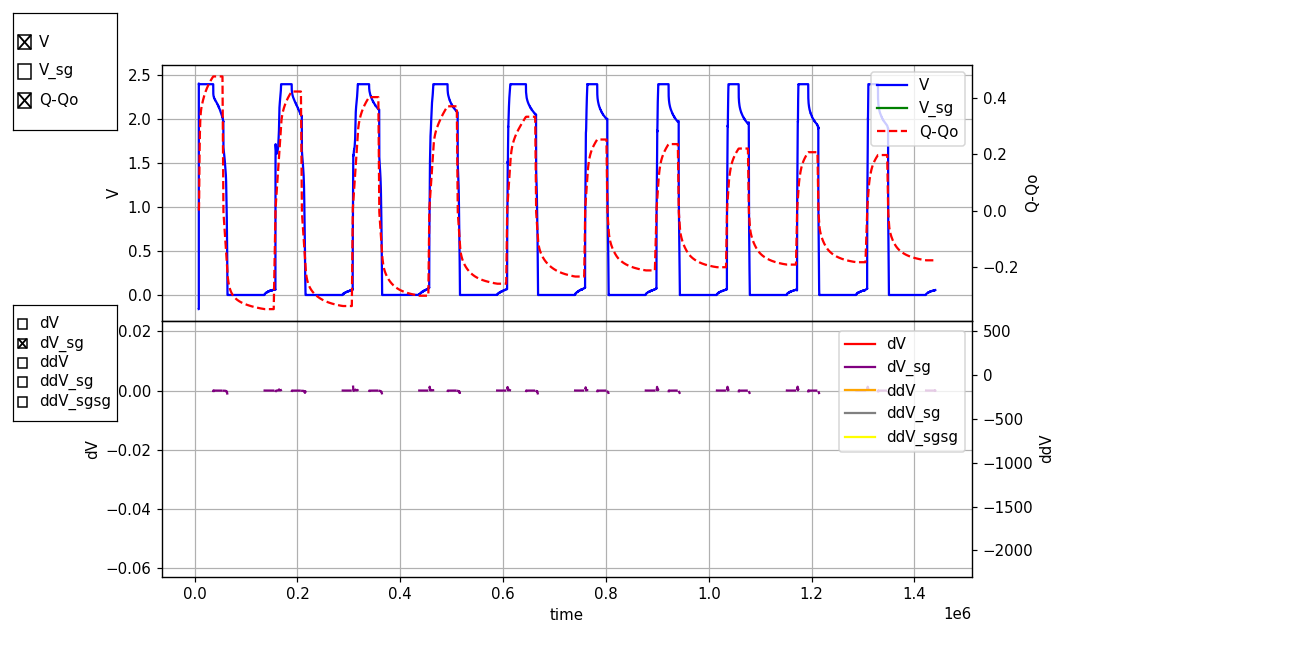

In [251]:
#plot the curves
%matplotlib notebook
## axis

fig,ax = plt.subplots(2,1,figsize=(12,6), sharex=True)
fig.subplots_adjust(right=0.75,top=0.9,hspace=.0)


ax[0].grid()
ax[1].grid()
ax1=ax[0].twinx()
ax2=ax[1].twinx()

ax[0].locator_params(axis='x', nbins=15)
# ax3=ax[1].twinx()
# ax2.spines.right.set_position(("axes", 1.2))


p1,=ax[0].plot(t,V, color="blue", label='V',visible=True)
p1_sg,= ax[0].plot(t,V_sg, color="green", label='V_sg',visible=True)
q, = ax1.plot(t,Q, color="red",linestyle='--', label='Q-Qo',visible=True)
p2,=ax[1].plot(t,dV, color="red", label='dV',visible=True)
p2_sg,=ax[1].plot(t,dV_sg, color="purple", label='dV_sg',visible=True)
# p2_df,=ax[1].plot(t,dV_df, color="cyan", label='dV_df',visible=True)
p3,=ax2.plot(t,ddV, color="orange", label='ddV',visible=True)
p3_sg,=ax2.plot(t,ddV_sg, color="grey", label='ddV_sg',visible=True)
p3_sgsg,=ax2.plot(t,ddV_sgsg, color="yellow", label='ddV_sg',visible=True)


fig.legend([p1,p1_sg,q],['V','V_sg','Q-Qo'],bbox_to_anchor=(0.75, 0.9))
fig.legend([p2,p2_sg,p3,p3_sg,p3_sgsg],['dV','dV_sg','ddV','ddV_sg','ddV_sgsg'],bbox_to_anchor=(0.75, 0.5))
p1_sg.set_visible(False)
p2.set_visible(False)
p2_sg.set_visible(False)
# p2_df.set_visible(False)
p3.set_visible(False)
p3_sg.set_visible(False)
p3_sgsg.set_visible(False)

ax[1].set_xlabel("time")
ax[0].set_ylabel("V")
ax1.set_ylabel("Q-Qo")
ax[1].set_ylabel("dV")
ax2.set_ylabel("ddV")
# ax3.set_ylabel("ddV")


## define the checkboxes
ax_cb1 = plt.axes([0.01,0.8,0.08,0.18])
ax_cb2 = plt.axes([0.01,0.35,0.08,0.18])

## properties of checkboxes
cbs1 = CheckButtons(ax_cb1,['V','V_sg','Q-Qo'],actives=[True,False,True])
cbs2 = CheckButtons(ax_cb2,['dV','dV_sg','ddV','ddV_sg','ddV_sgsg'],actives=[False,False,False,False,False,False])
## updating function
def update(val):
    status1 = cbs1.get_status()
    status2 = cbs2.get_status()
    p1.set_visible(status1[0])
    p1_sg.set_visible(status1[1])
    q.set_visible(status1[2])
    p2.set_visible(status2[0])
    p2_sg.set_visible(status2[1])
#     p2_df.set_visible(status2[2])
    p3.set_visible(status2[2])
    p3_sg.set_visible(status2[3])
    p3_sgsg.set_visible(status2[4])
    
    fig.canvas.draw()
    
cbs1.on_clicked(update)
cbs2.on_clicked(update)

plt.show()

# $V$,$\frac {dV}{dQ}$,$\frac{d(\frac {dV}{dQ})}{dQ}$ vs. Q

In [264]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
# db=np.unique([x.split('_')[0] for x in datafilespath])
v_dV_ddV_Q=[]
cell='Cell005'
Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

sql = 'SELECT `Ewe/V`,`(Q-Qo)/mA.h`,`loop_Nr` FROM ' +cell+ '.gcpl'
cellx_df = pd.read_sql(sql, Connection)

V = cellx_df['Ewe/V']
loop = cellx_df['loop_Nr']
#savgol_filter
win_len = 179
p_order = 3
V_sg = savgol_filter(V,win_len,p_order)

Q =cellx_df['(Q-Qo)/mA.h']
#     dV = np.divide(np.diff(V_sg,append=-1),np.diff(Q,append=-1))
#     ddV = np.divide(np.diff(dV,append=-1),np.diff(Q,append=-1))
#     v_dV_ddV_Q = {'V':V,'V_sg':V_sg,'dV':dV,'ddV':ddV,'Q':Q}
#     v_dV_ddV_Q = pd.DataFrame(data=v_dV_ddV_Q)    
#     engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
#     v_dV_ddV_Q.to_sql('v_dv_ddv_q', engine, if_exists='replace',index=False)
#     print('table v_dv_ddv_q of '+cell +' created')

## $V$ vs. Q

<IPython.core.display.Javascript object>


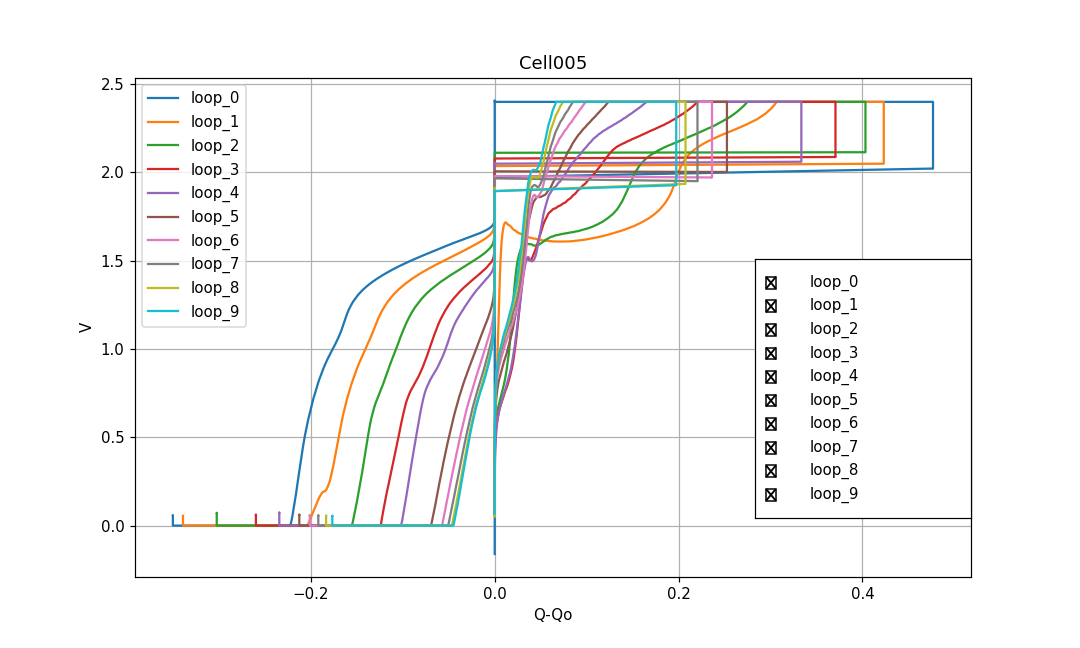

0

In [265]:
fig,ax = plt.subplots(figsize=(10,6))
plt.title(cell)
l = ax.plot(
    Q[loop==0],V[loop==0],
    Q[loop==1],V[loop==1],
    Q[loop==2],V[loop==2],
    Q[loop==3],V[loop==3],
    Q[loop==4],V[loop==4],
    Q[loop==5],V[loop==5],
    Q[loop==6],V[loop==6],
    Q[loop==7],V[loop==7],
    Q[loop==8],V[loop==8],
    Q[loop==9],V[loop==9]
       )
ax.legend(['loop_0','loop_1','loop_2','loop_3','loop_4','loop_5','loop_6','loop_7','loop_8','loop_9'])
ax.set_xlabel("Q-Qo")
ax.set_ylabel("V")
ax.grid()
## define the checkboxes
ax_cb = plt.axes([0.7,0.2,0.2,0.4])
cbs = CheckButtons(ax_cb,['loop_0','loop_1','loop_2','loop_3','loop_4','loop_5','loop_6','loop_7','loop_8','loop_9'],
                    actives=[True,True,True,True,True,True,True,True,True,True])

## updating function
def update(val):
    status = cbs.get_status()
    l[0].set_visible(status[0])
    l[1].set_visible(status[1])
    l[2].set_visible(status[2])
    l[3].set_visible(status[3])
    l[4].set_visible(status[4])
    l[5].set_visible(status[5])
    l[6].set_visible(status[6])
    l[7].set_visible(status[7])
    l[8].set_visible(status[8])
    l[9].set_visible(status[9])
    fig.canvas.draw()
cbs.on_clicked(update)

## $\frac {dV}{dQ}$vs. Q

<IPython.core.display.Javascript object>


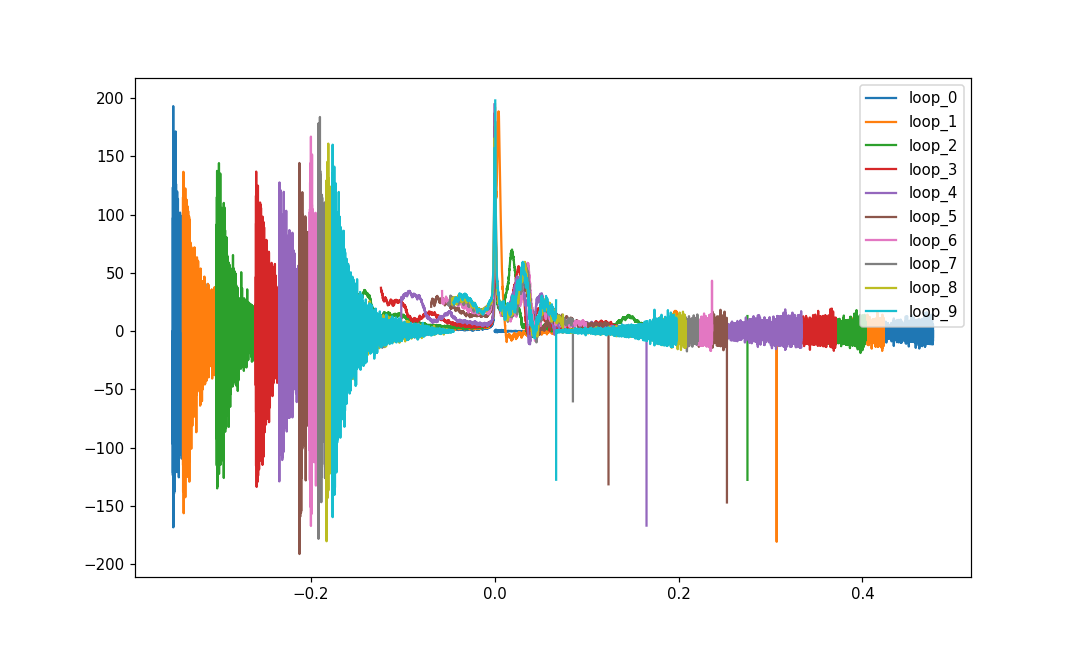

In [266]:
fig,ax = plt.subplots(figsize=(10,6))
l=[]
#savgol_filter
win_len = 179
p_order = 3
for i in range(0,10):
    dV = np.diff(V[loop==i],append=-1)
    dQ = np.diff(Q[loop==i],append=-1)
    dVdQ = np.zeros(dV.shape)
    idxNonZeros = np.where(dQ!=0)
    idxZeros = np.where(dQ==0)
    dVdQ[idxNonZeros] = dV[idxNonZeros]/dQ[idxNonZeros]
    dVdQ[idxZeros] = np.nan
    
    dVdQ[abs(dVdQ)>=200]=np.nan
    
    l = ax.plot(Q[loop==i],dVdQ)
ax.legend(['loop_0','loop_1','loop_2','loop_3','loop_4','loop_5','loop_6','loop_7','loop_8','loop_9'])

# EIS